In [ ]:
!pip install stldecompose
!pip install statsmodels==0.10.2
!pip install ml_metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-py3-none-any.whl size=7845 sha256=b69fdeda5059f11c85b71331bc28f3a931b680bd940e5676ce2112d32871419c
  Stored in directory: /root/.cache/pip/wheels/56/41/5b/0c6d42b3604a5c823d8922564c4708f84962fa7f2f4facfa6d
Successfully built ml-metrics


### Классический обзор и ARIMA

In [ ]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import holidays
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
from fbprophet import Prophet
import itertools
import random
from datetime import datetime

import time
from tqdm import tqdm
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

import scipy.stats as st
from fbprophet.plot import add_changepoints_to_plot, plot_forecast_component
from fbprophet.plot import plot_yearly

from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels as sm

import matplotlib.pyplot as plt
%matplotlib inline


from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Techno_project/train.csv")
df

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0
...,...,...,...,...,...,...
35990,35991,NaN,Zimbabwe,2020-05-11,36.0,4.0
35991,35992,NaN,Zimbabwe,2020-05-12,36.0,4.0
35992,35993,NaN,Zimbabwe,2020-05-13,37.0,4.0
35993,35994,NaN,Zimbabwe,2020-05-14,37.0,4.0


In [ ]:
total = df.drop("Id", axis = 1).groupby("Date", as_index = False).sum()
total["Country_Region"] = "Total"
total

,Date,ConfirmedCases,Fatalities,Country_Region
0,2020-01-22,554.0,17.0,Total
1,2020-01-23,653.0,18.0,Total
2,2020-01-24,939.0,26.0,Total
3,2020-01-25,1432.0,42.0,Total
4,2020-01-26,2113.0,56.0,Total
...,...,...,...,...
110,2020-05-11,4176589.0,286293.0,Total
111,2020-05-12,4260955.0,291924.0,Total
112,2020-05-13,4345950.0,297155.0,Total
113,2020-05-14,4440974.0,302370.0,Total


In [ ]:
df_with_total = pd.concat([df, total], join = "inner", ignore_index = True)
df_with_total = df_with_total.loc[df_with_total["Country_Region"].isin(["Russia", "Total"])].sort_values(by=['Country_Region','Date'])
df_with_total

,Country_Region,Date,ConfirmedCases,Fatalities
23460,Russia,2020-01-22,0.0,0.0
23461,Russia,2020-01-23,0.0,0.0
23462,Russia,2020-01-24,0.0,0.0
23463,Russia,2020-01-25,0.0,0.0
23464,Russia,2020-01-26,0.0,0.0
...,...,...,...,...
36105,Total,2020-05-11,4176589.0,286293.0
36106,Total,2020-05-12,4260955.0,291924.0
36107,Total,2020-05-13,4345950.0,297155.0
36108,Total,2020-05-14,4440974.0,302370.0


In [ ]:
df_with_total.Date = pd.to_datetime(df_with_total.Date)

iplot([
    go.Scatter(x=df_with_total.head(115).Date , y=df_with_total.ConfirmedCases \
               .loc[df_with_total["Country_Region"] == "Russia"], name='fact_Russia'),
    go.Scatter(x=df_with_total.tail(115).Date , y=df_with_total.ConfirmedCases \
               .loc[df_with_total["Country_Region"] == "Total"], name='fact_Total')
]);
plt.show()

In [ ]:
iplot([
    go.Scatter(x=df_with_total.head(115).Date , y=df_with_total.ConfirmedCases \
               .loc[df_with_total["Country_Region"] == "Russia"], name='fact_Russia')
]);
plt.show()

In [ ]:
iplot([
    go.Scatter(x=df_with_total.tail(115).Date , y=df_with_total.ConfirmedCases \
               .loc[df_with_total["Country_Region"] == "Total"], name='fact_Total')
]);
plt.show()

Best degree 25 with RMSE 694.5020434243694,
		 25 with MAE 420.12970480493414,
		 25 with R2 0.9998992085358996


Text(0, 0.5, 'RMSE')

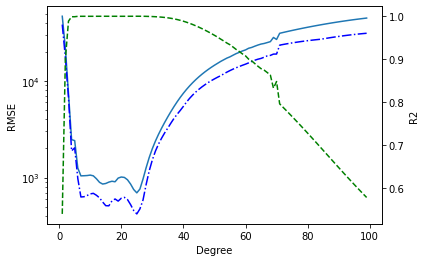

In [ ]:
# https://stackoverflow.com/questions/47442102/how-to-find-the-best-degree-of-polynomials
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from datetime import datetime

from sklearn.metrics import r2_score
import ml_metrics as metrics

n_data = len(df_with_total['Date'])//2
X = np.arange(n_data).reshape(n_data, 1)
y = np.array(df_with_total.loc[df_with_total["Country_Region"] == "Russia"]["ConfirmedCases"])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

rmses = []
maes = []
r2_scores = []
degrees = np.arange(1, 100)
min_rmse, min_mae, min_r2, min_deg, min_deg_mae, min_deg_r2 = 1e10, 1e10, 0.01, 0, 0, 0

for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(x_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(x_test)
    poly_predict = poly_reg.predict(x_poly_test)
    
    # 1. RMSE:
    poly_mse = mean_squared_error(y_test, poly_predict) # Mean Square Error
    poly_rmse = np.sqrt(poly_mse) # Root Mean Square Root
    rmses.append(poly_rmse)
    
    # 2. MAE:
    poly_mae = mean_absolute_error(y_test, poly_predict)
    maes.append(poly_mae)
    
    # 3. R2 - score:
    poly_r2_score = r2_score(y_test.tolist(), poly_predict.tolist())
    r2_scores.append(poly_r2_score)

    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg
    if min_mae > poly_mae:
        min_mae = poly_mae
        min_deg_mae = deg
    if min_r2 < poly_r2_score:
        min_r2 = poly_r2_score
        min_deg_r2 = deg

# Plot and present results
print('Best degree {} with RMSE {},\n\t\t {} with MAE {},\n\t\t {} with R2 {}'.format(min_deg, min_rmse, min_deg_mae, min_mae, min_deg_r2, min_r2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax2 = ax.twinx()
ax.plot(degrees, maes, 'b-.')
ax2.plot(degrees, r2_scores, 'g--')
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax2.set_ylabel('R2')
ax.set_ylabel('MAE')
ax.set_ylabel('RMSE')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning:

Polyfit may be poorly conditioned





R^2: 0.999986173
RMSE: 245.463165754
MAE: 150.601306392


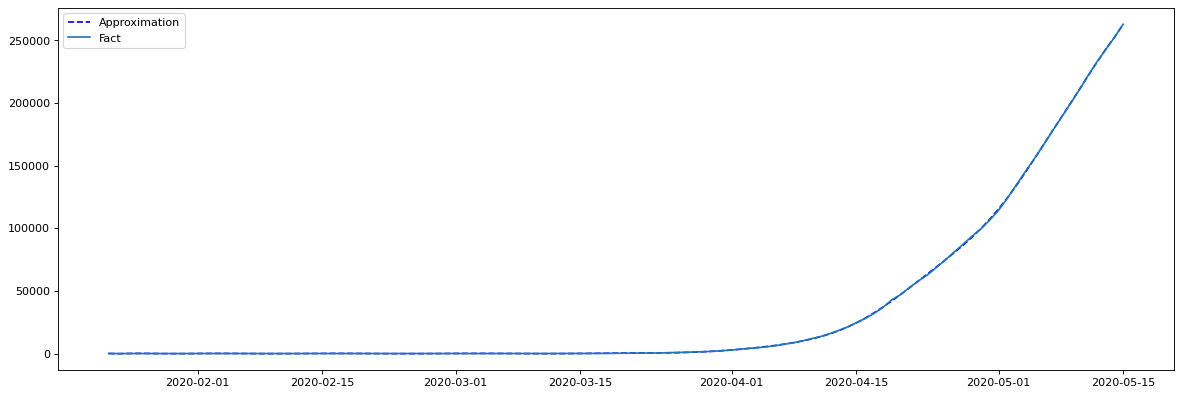

In [ ]:
min_deg = 25
model = np.polyfit(x = np.arange(n_data), y = np.array(df_with_total.loc[df_with_total["Country_Region"] == "Russia"]["ConfirmedCases"]), deg = min_deg)
polynom = np.poly1d(model)

plt.figure(figsize=(18, 6), dpi=80)
plt.plot(df_with_total.tail(n_data).Date, polynom( np.arange(n_data) ), 'b--', label = "Approximation")
plt.plot(df_with_total.tail(n_data).Date,  np.array(df_with_total.loc[df_with_total["Country_Region"] == "Russia"]["ConfirmedCases"]), label = "Fact")
plt.legend()

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import ml_metrics as metrics

print ('\n\nR^2: %1.9f' % r2_score(df_with_total.loc[df_with_total["Country_Region"] == "Russia"]["ConfirmedCases"], polynom( np.arange(n_data) )))
print ('RMSE: %.9f' % np.sqrt(mean_squared_error(df_with_total.loc[df_with_total["Country_Region"] == "Russia"]["ConfirmedCases"], polynom( np.arange(n_data) ))))
print ('MAE: %.9f' % mean_absolute_error(df_with_total.loc[df_with_total["Country_Region"] == "Russia"]["ConfirmedCases"], polynom( np.arange(n_data) )))


In [ ]:
df_russia = df_with_total.loc[df_with_total["Country_Region"] == "Russia"]
df_total = df_with_total.loc[df_with_total["Country_Region"] == "Total"]

df_russia["Conf_diff"] = df_russia['ConfirmedCases']-df_russia['ConfirmedCases'].shift(1)
df_russia["Fatal_diff"] = df_russia['Fatalities']-df_russia['Fatalities'].shift(1)
df_russia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Country_Region,Date,ConfirmedCases,Fatalities,Conf_diff,Fatal_diff
23460,Russia,2020-01-22,0.0,0.0,NaN,NaN
23461,Russia,2020-01-23,0.0,0.0,0.0,0.0
23462,Russia,2020-01-24,0.0,0.0,0.0,0.0
23463,Russia,2020-01-25,0.0,0.0,0.0,0.0
23464,Russia,2020-01-26,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
23570,Russia,2020-05-11,221344.0,2009.0,11656.0,94.0
23571,Russia,2020-05-12,232243.0,2116.0,10899.0,107.0
23572,Russia,2020-05-13,242271.0,2212.0,10028.0,96.0
23573,Russia,2020-05-14,252245.0,2305.0,9974.0,93.0


In [ ]:
iplot([
    go.Scatter(x=df_russia.Date , y=df_russia.Conf_diff, name='Conf_diff_Russia'),
    go.Scatter(x=df_russia.Date , y=df_russia.Fatal_diff, name='Fatal_diff_Russia')
]);
plt.show()

In [ ]:
iplot([
    go.Scatter(x=df_russia.Date , y=df_russia.Conf_diff, name='Conf_diff_Russia')
]);
plt.show()

In [ ]:
iplot([
    go.Scatter(x=df_russia.Date , y=df_russia.Fatal_diff, name='Fatal_diff_Russia')
]);
plt.show()

In [ ]:
df_total["Conf_diff"] = df_total['ConfirmedCases']-df_total['ConfirmedCases'].shift(1)
df_total["Fatal_diff"] = df_total['Fatalities']-df_total['Fatalities'].shift(1)
df_total

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Country_Region,Date,ConfirmedCases,Fatalities,Conf_diff,Fatal_diff
35995,Total,2020-01-22,554.0,17.0,NaN,NaN
35996,Total,2020-01-23,653.0,18.0,99.0,1.0
35997,Total,2020-01-24,939.0,26.0,286.0,8.0
35998,Total,2020-01-25,1432.0,42.0,493.0,16.0
35999,Total,2020-01-26,2113.0,56.0,681.0,14.0
...,...,...,...,...,...,...
36105,Total,2020-05-11,4176589.0,286293.0,75746.0,3619.0
36106,Total,2020-05-12,4260955.0,291924.0,84366.0,5631.0
36107,Total,2020-05-13,4345950.0,297155.0,84995.0,5231.0
36108,Total,2020-05-14,4440974.0,302370.0,95024.0,5215.0


In [ ]:
iplot([
    go.Scatter(x=df_total.Date , y=df_total.Conf_diff, name='Conf_diff_Total'),
    go.Scatter(x=df_total.Date , y=df_total.Fatal_diff, name='Fatal_diff_Total')
]);
plt.show()

In [ ]:
iplot([
    go.Scatter(x=df_total.Date , y=df_total.Conf_diff, name='Conf_diff_Total')
]);
plt.show()

In [ ]:
iplot([
       go.Scatter(x=df_total.Date , y=df_total.Fatal_diff, name='Fatal_diff_Total')
]);
plt.show()

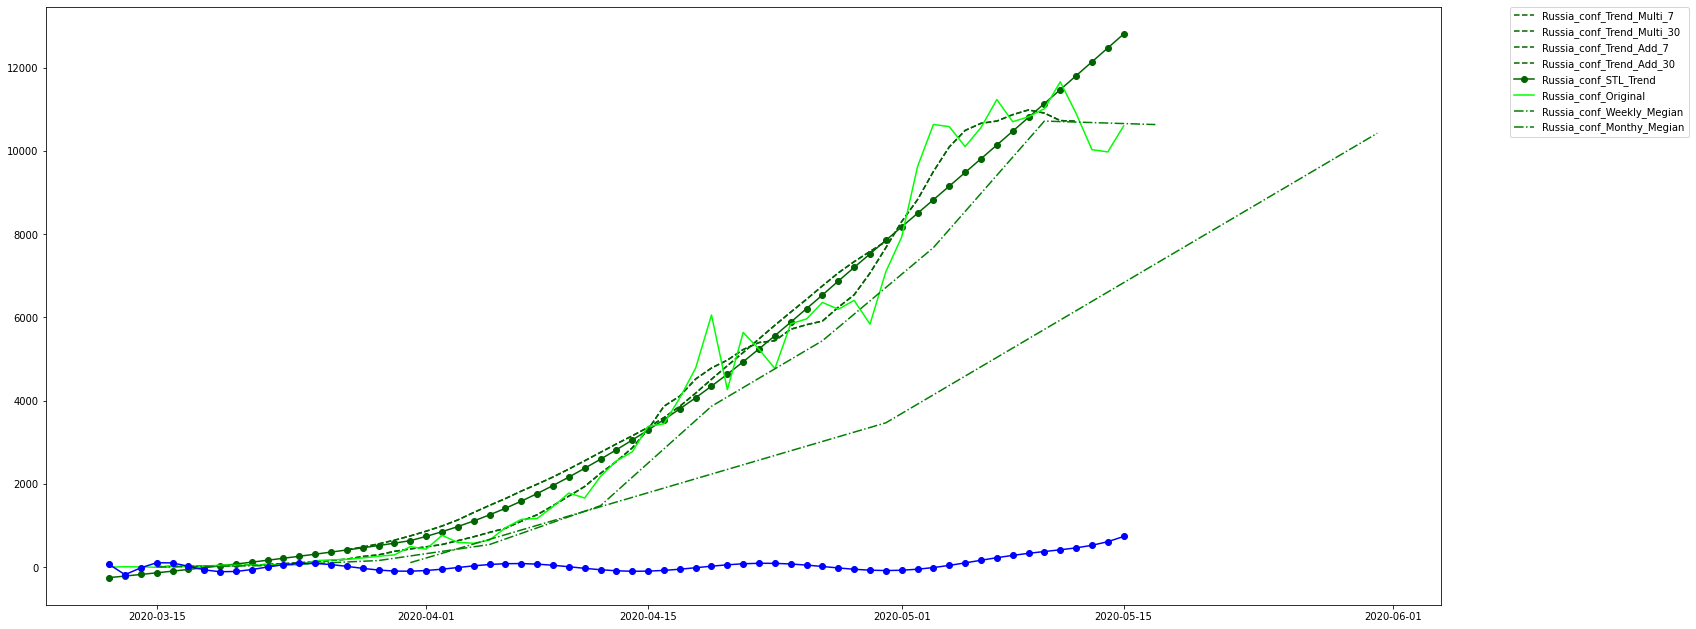

In [ ]:
import matplotlib
matplotlib.colors
matplotlib.colors.rgb_to_hsv
matplotlib.colors.to_rgba
matplotlib.figure.Figure.get_size_inches
matplotlib.figure.Figure.subplots_adjust
matplotlib.axes.Axes.text
matplotlib.axes.Axes.hlines


dta = df_russia
dta = dta.set_index('Date')[50:] #данные пришлось обрезать ради избежания ошибок (нельзя, чтобы были нулевые значения и NaN)

# 1. Multiplicative 
# 1.1. Weekly
res_ymw = seasonal_decompose(dta['Conf_diff'], model='multiplicative', freq = 7)
# 1.2. Monthly
res_ymm = seasonal_decompose(dta['Conf_diff'], model='multiplicative', freq = 30)

# 2. Additive 
# 2.1. Weekly
res_yaw = seasonal_decompose(dta['Conf_diff'], model='additive', freq = 7)
# 2.2. Monthly
res_yam = seasonal_decompose(dta['Conf_diff'], model='additive', freq = 30)

# 3. STL-Lib Decompopsition by LOESS - Logistic Regression:
stl_y = decompose(dta['Conf_diff'], period=7)


# Just Aggregation:
# 1. Not Aggregated:
res_y = dta.Conf_diff

# 2. Aggregated by Week (Moving Median):
res_ymedw = dta.Conf_diff.resample('W').mean()

# 3. Aggregated by Month (Moving Median):
res_ymedm = dta.Conf_diff.resample('M').mean()


# Plotting Charts:
plt.figure(figsize=(25,11))
plt.plot(res_ymw.trend, '--', label='Russia_conf_Trend_Multi_7', color='darkgreen')
plt.plot(res_ymm.trend, '--', label='Russia_conf_Trend_Multi_30', color='darkgreen')
plt.plot(res_yaw.trend, '--', label='Russia_conf_Trend_Add_7', color='darkgreen')
plt.plot(res_yam.trend, '--', label='Russia_conf_Trend_Add_30', color='darkgreen')
plt.plot(stl_y.trend, '-o', label='Russia_conf_STL_Trend', color='darkgreen')

plt.plot(dta['Conf_diff'], '-', label='Russia_conf_Original', color='lime')
plt.plot(res_ymedw, 'g-.', label='Russia_conf_Weekly_Megian')
plt.plot(res_ymedm, 'g-.', label='Russia_conf_Monthy_Megian')
plt.plot(dta.index, polynom( np.arange(len(dta.index)) ), 'b-o')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

ADF:  -0.016044042970765574
p-value:  0.9571849715993687
Critical values:  {'1%': -3.53692771987915, '5%': -2.907887369384766, '10%': -2.591493291015625}
есть единичные корни, ряд не стационарен
ADF:  -8.604018557063693
p-value:  6.748443830431153e-14
Critical values:  {'1%': -3.5386953618719676, '5%': -2.9086446751210775, '10%': -2.591896782564878}
единичных корней нет, ряд стационарен


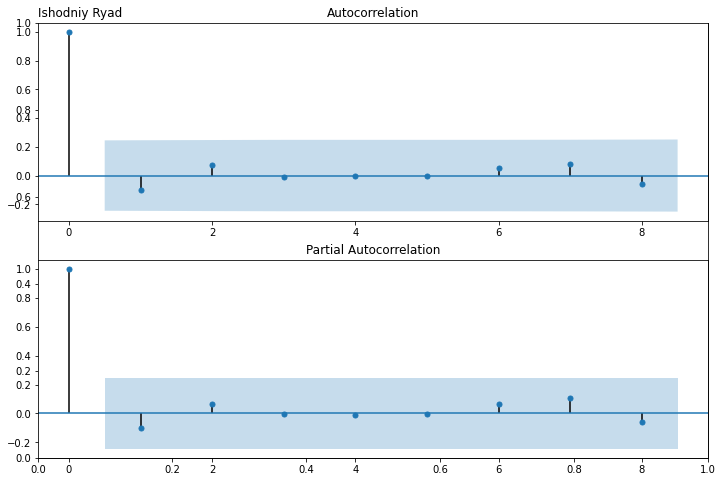

In [ ]:
trend = pd.DataFrame(data=(dta.Conf_diff - polynom(np.arange(len(dta))) ) )
y1diff = trend.diff(periods=1).dropna() 

test = sm.tsa.stattools.adfuller(trend.iloc[:,0].values)
print('ADF: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print( 'есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')
# Единичные корни: Первая разность ряда
test = sm.tsa.stattools.adfuller(y1diff.iloc[:,0].values)
print('ADF: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')
    
y2diff = trend.diff(periods=2).dropna() # Вторая разность ряда   
# Единичные корни: Вторая разность ряда
# test = sm.tsa.stattools.adfuller(y2diff.iloc[:,0].values)
# print('ADF: ', test[0])
# print('p-value: ', test[1])
# print('Critical values: ', test[4])
# if test[0]> test[4]['5%']: 
#     print('есть единичные корни, ряд не стационарен')
# else:
#     print('единичных корней нет, ряд стационарен')

fig = plt.figure(figsize=(12,8))
plt.title('Ishodniy Ryad', loc='left')
ax1 = fig.add_subplot(211)
fig = sm.api.graphics.tsa.plot_acf(y1diff.iloc[:,0].values.squeeze(), lags=8, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.api.graphics.tsa.plot_pacf(y1diff, lags=8
                                    , ax=ax2)


In [ ]:
res_ymw.trend

Date
2020-03-12             NaN
2020-03-13             NaN
2020-03-14             NaN
2020-03-15       18.142857
2020-03-16       24.428571
                  ...     
2020-05-11    10726.428571
2020-05-12    10712.000000
2020-05-13             NaN
2020-05-14             NaN
2020-05-15             NaN
Name: Conf_diff, Length: 65, dtype: float64

Судя по графикам, получаем, что p=1, q = 1, а также берём во внимание, что d = 1. Сделаем предсказание на неделю вперёд:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



R^2: -5016.53
MAPE: 96.148256
MAE: 10343.674193


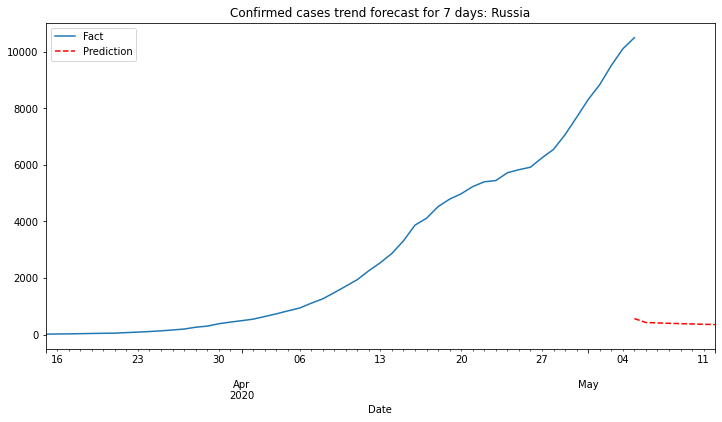

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error
import ml_metrics as metrics

src_data_model = res_ymw.trend['2020-03-15':'2020-05-05'].apply(lambda x: int(x))

model = sm.tsa.arima_model.ARIMA(src_data_model, (1,1,1))
model = model.fit()

from sklearn.metrics import r2_score
import ml_metrics as metrics

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

pred = model.predict('2020-05-05', '2020-05-12')
trn = res_ymw.trend['2020-05-05':'2020-05-12']
r2 = r2_score(trn, pred)
print('R^2: %1.2f' % r2)
print('MAPE: %f' % MAPE(trn, pred))
print('MAE: %f' % mean_absolute_error(trn, pred))

res_ymw.trend['2020-03-15':'2020-05-05'].apply(lambda x: int(x)).plot(figsize=(12,6), label = "Fact")
#src_data_model.plot()
pred.plot(style='r--', label = "Prediction")
plt.title("Confirmed cases trend forecast for 7 days: Russia")
plt.legend()


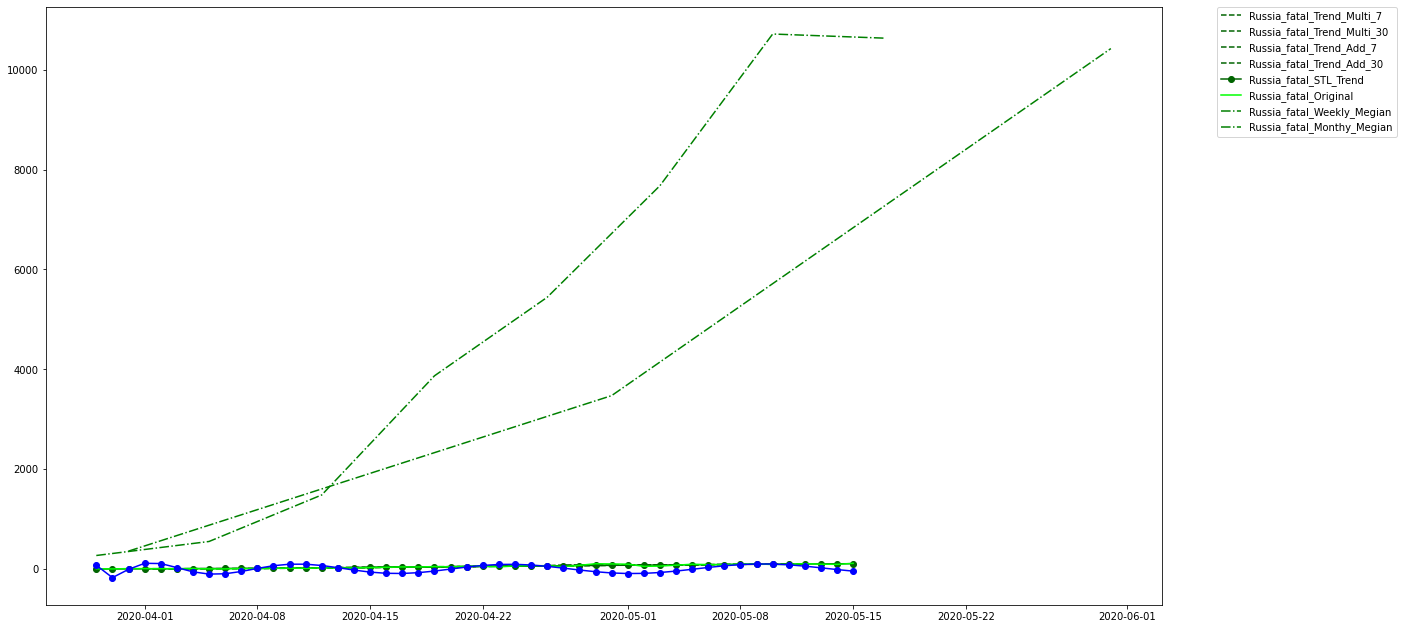

In [ ]:
dta = df_russia
dta = dta.set_index('Date')[67:] #данные пришлось обрезать ради избежания ошибок (нельзя, чтобы были нулевые значения и NaN)
res_ymw = seasonal_decompose(dta['Fatal_diff'], model='multiplicative', freq = 7)
# 1.2. Monthly
res_ymm = seasonal_decompose(dta['Fatal_diff'], model='multiplicative', freq = 30)

# 2. Additive 
# 2.1. Weekly
res_yaw = seasonal_decompose(dta['Fatal_diff'], model='additive', freq = 7)
# 2.2. Monthly
res_yam = seasonal_decompose(dta['Fatal_diff'], model='additive', freq = 30)

# 3. STL-Lib Decompopsition by LOESS - Logistic Regression:
stl_y = decompose(dta['Fatal_diff'], period=7)


# Just Aggregation:
# 1. Not Aggregated:
res_y = dta.Conf_diff

# 2. Aggregated by Week (Moving Median):
res_ymedw = dta.Conf_diff.resample('W').mean()

# 3. Aggregated by Month (Moving Median):
res_ymedm = dta.Conf_diff.resample('M').mean()


# Plotting Charts:
plt.figure(figsize=(20,11))
plt.plot(res_ymw.trend, '--', label='Russia_fatal_Trend_Multi_7', color='darkgreen')
plt.plot(res_ymm.trend, '--', label='Russia_fatal_Trend_Multi_30', color='darkgreen')
plt.plot(res_yaw.trend, '--', label='Russia_fatal_Trend_Add_7', color='darkgreen')
plt.plot(res_yam.trend, '--', label='Russia_fatal_Trend_Add_30', color='darkgreen')
plt.plot(stl_y.trend, '-o', label='Russia_fatal_STL_Trend', color='darkgreen')

plt.plot(dta['Fatal_diff'], '-', label='Russia_fatal_Original', color='lime')
plt.plot(res_ymedw, 'g-.', label='Russia_fatal_Weekly_Megian')
plt.plot(res_ymedm, 'g-.', label='Russia_fatal_Monthy_Megian')
plt.plot(dta.index, polynom( np.arange(len(dta.index)) ), 'b-o')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

ADF:  -4.341629962400497
p-value:  0.0003759828036151568
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
единичных корней нет, ряд стационарен
ADF:  -3.690207191172048
p-value:  0.004253026403069314
Critical values:  {'1%': -3.60098336718852, '5%': -2.9351348158036012, '10%': -2.6059629803688282}
единичных корней нет, ряд стационарен


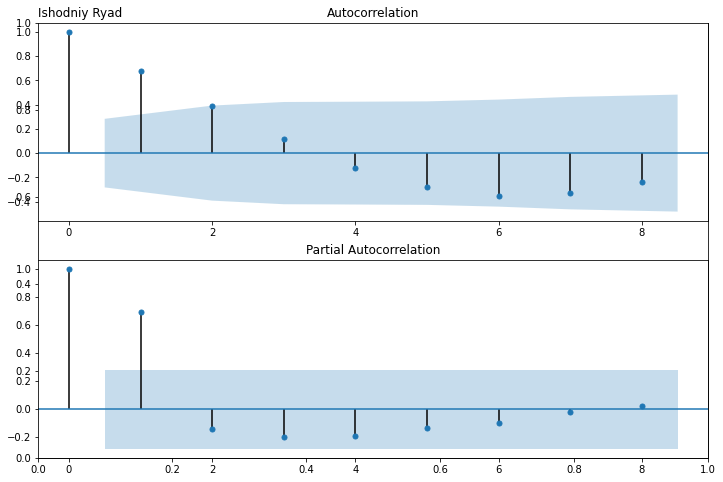

In [ ]:
trend = pd.DataFrame(data=(dta.Fatal_diff - polynom(np.arange(len(dta))) ) )
y1diff = trend.diff(periods=1).dropna() 

test = sm.tsa.stattools.adfuller(trend.iloc[:,0].values)
print('ADF: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print( 'есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')
# Единичные корни: Первая разность ряда
test = sm.tsa.stattools.adfuller(y1diff.iloc[:,0].values)
print('ADF: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')
    
y2diff = trend.diff(periods=2).dropna() # Вторая разность ряда   
# Единичные корни: Вторая разность ряда
# test = sm.tsa.stattools.adfuller(y2diff.iloc[:,0].values)
# print('ADF: ', test[0])
# print('p-value: ', test[1])
# print('Critical values: ', test[4])
# if test[0]> test[4]['5%']: 
#     print('есть единичные корни, ряд не стационарен')
# else:
#     print('единичных корней нет, ряд стационарен')

fig = plt.figure(figsize=(12,8))
plt.title('Ishodniy Ryad', loc='left')
ax1 = fig.add_subplot(211)
fig = sm.api.graphics.tsa.plot_acf(trend.iloc[:,0].values.squeeze(), lags=8, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.api.graphics.tsa.plot_pacf(trend, lags=8
                                    , ax=ax2)


In [ ]:
res_ymw.trend

Date
2020-03-29          NaN
2020-03-30          NaN
2020-03-31          NaN
2020-04-01     5.571429
2020-04-02     5.285714
2020-04-03     5.428571
2020-04-04     5.857143
2020-04-05     5.571429
2020-04-06     6.571429
2020-04-07     8.571429
2020-04-08     9.000000
2020-04-09    12.142857
2020-04-10    14.428571
2020-04-11    16.000000
2020-04-12    19.285714
2020-04-13    22.285714
2020-04-14    25.571429
2020-04-15    29.571429
2020-04-16    33.000000
2020-04-17    36.714286
2020-04-18    40.857143
2020-04-19    45.000000
2020-04-20    46.142857
2020-04-21    48.857143
2020-04-22    52.571429
2020-04-23    55.142857
2020-04-24    55.571429
2020-04-25    58.714286
2020-04-26    65.571429
2020-04-27    74.000000
2020-04-28    79.142857
2020-04-29    77.285714
2020-04-30    76.142857
2020-05-01    80.285714
2020-05-02    83.428571
2020-05-03    80.714286
2020-05-04    78.857143
2020-05-05    79.142857
2020-05-06    86.428571
2020-05-07    90.714286
2020-05-08    93.285714
2020-05-09 

Считаем, что p=3, q = 2, а d = 0. Сделаем предсказание на неделю вперёд:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



R^2: -13.85
MAPE: 2.060334
MAE: 1758.743612


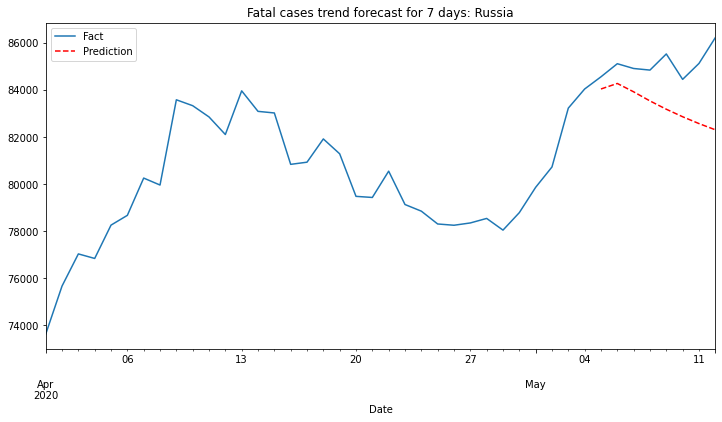

In [ ]:
src_data_model = res_ymw.trend['2020-04-01':'2020-05-05'].apply(lambda x: int(x))

model = sm.tsa.arima_model.ARIMA(src_data_model, (1,0,2))
model = model.fit()

pred = model.predict('2020-05-05', '2020-05-12')
trn = res_ymw.trend['2020-05-05':'2020-05-12']
r2 = r2_score(trn, pred)
print('R^2: %1.2f' % r2)
print('MAPE: %f' % MAPE(trn, pred))
print('MAE: %f' % mean_absolute_error(trn, pred))

res_ymw.trend['2020-04-01' : '2020-05-12'].apply(lambda x: int(x)).plot(figsize=(12,6), label = "Fact")
#src_data_model.plot()
pred.plot(style='r--', label = "Prediction")
plt.title("Fatal cases trend forecast for 7 days: Russia")
plt.legend()


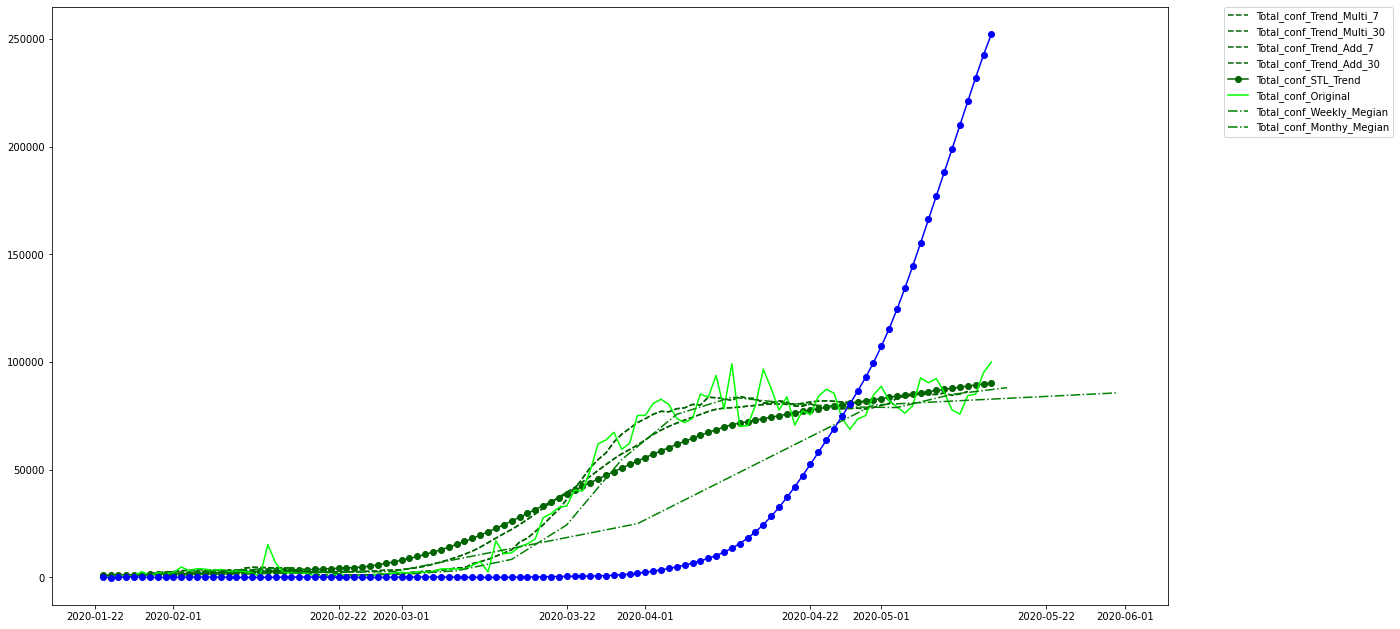

In [ ]:
dta = df_total
dta = dta.set_index('Date')[1:] #данные пришлось обрезать ради избежания ошибок (нельзя, чтобы были нулевые значения и NaN)

# 1. Multiplicative 
# 1.1. Weekly
res_ymw = seasonal_decompose(dta['Conf_diff'], model='multiplicative', freq = 7)
# 1.2. Monthly
res_ymm = seasonal_decompose(dta['Conf_diff'], model='multiplicative', freq = 30)

# 2. Additive 
# 2.1. Weekly
res_yaw = seasonal_decompose(dta['Conf_diff'], model='additive', freq = 7)
# 2.2. Monthly
res_yam = seasonal_decompose(dta['Conf_diff'], model='additive', freq = 30)

# 3. STL-Lib Decompopsition by LOESS - Logistic Regression:
stl_y = decompose(dta['Conf_diff'], period=7)


# Just Aggregation:
# 1. Not Aggregated:
res_y = dta.Conf_diff

# 2. Aggregated by Week (Moving Median):
res_ymedw = dta.Conf_diff.resample('W').mean()

# 3. Aggregated by Month (Moving Median):
res_ymedm = dta.Conf_diff.resample('M').mean()


# Plotting Charts:
plt.figure(figsize=(20,11))
plt.plot(res_ymw.trend, '--', label='Total_conf_Trend_Multi_7', color='darkgreen')
plt.plot(res_ymm.trend, '--', label='Total_conf_Trend_Multi_30', color='darkgreen')
plt.plot(res_yaw.trend, '--', label='Total_conf_Trend_Add_7', color='darkgreen')
plt.plot(res_yam.trend, '--', label='Total_conf_Trend_Add_30', color='darkgreen')
plt.plot(stl_y.trend, '-o', label='Total_conf_STL_Trend', color='darkgreen')

plt.plot(dta['Conf_diff'], '-', label='Total_conf_Original', color='lime')
plt.plot(res_ymedw, 'g-.', label='Total_conf_Weekly_Megian')
plt.plot(res_ymedm, 'g-.', label='Total_conf_Monthy_Megian')
plt.plot(dta.index, polynom( np.arange(len(dta.index)) ), 'b-o')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

ADF:  -2.3674804324854333
p-value:  0.15112591617580828
Critical values:  {'1%': -3.4961490537199116, '5%': -2.8903209639580556, '10%': -2.5821223452518263}
есть единичные корни, ряд не стационарен
ADF:  0.010346002001373903
p-value:  0.9593793757652791
Critical values:  {'1%': -3.4961490537199116, '5%': -2.8903209639580556, '10%': -2.5821223452518263}
есть единичные корни, ряд не стационарен
ADF:  -0.11281678032956975
p-value:  0.948146874337283
Critical values:  {'1%': -3.4961490537199116, '5%': -2.8903209639580556, '10%': -2.5821223452518263}
есть единичные корни, ряд не стационарен


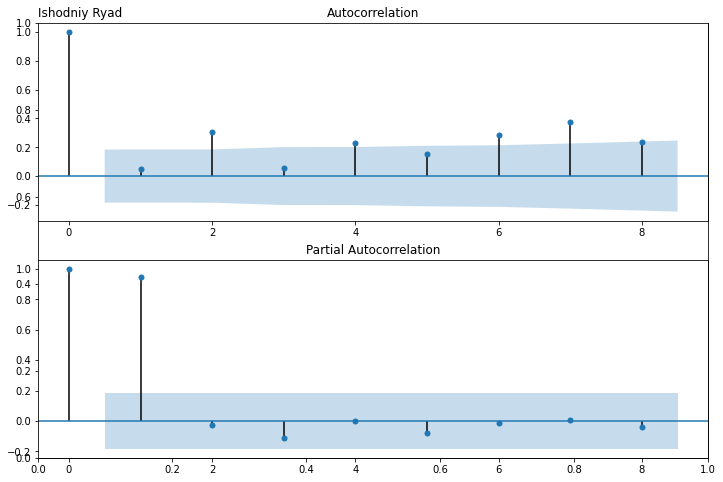

In [ ]:
trend = pd.DataFrame(data=(dta.Conf_diff - polynom(np.arange(len(dta))) ) )
y1diff = trend.diff(periods=1).dropna() 

test = sm.tsa.stattools.adfuller(trend.iloc[:,0].values)
print('ADF: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print( 'есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')
# Единичные корни: Первая разность ряда
test = sm.tsa.stattools.adfuller(y1diff.iloc[:,0].values)
print('ADF: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')
    
y2diff = trend.diff(periods=2).dropna() # Вторая разность ряда   
#Единичные корни: Вторая разность ряда
test = sm.tsa.stattools.adfuller(y2diff.iloc[:,0].values)
print('ADF: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

fig = plt.figure(figsize=(12,8))
plt.title('Ishodniy Ryad', loc='left')
ax1 = fig.add_subplot(211)
fig = sm.api.graphics.tsa.plot_acf(y1diff.iloc[:,0].values.squeeze(), lags=8, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.api.graphics.tsa.plot_pacf(trend, lags=8
                                    , ax=ax2)


Ряд не удалось сделать стационарным, поэтому ARIMA-модель здесь не применима.

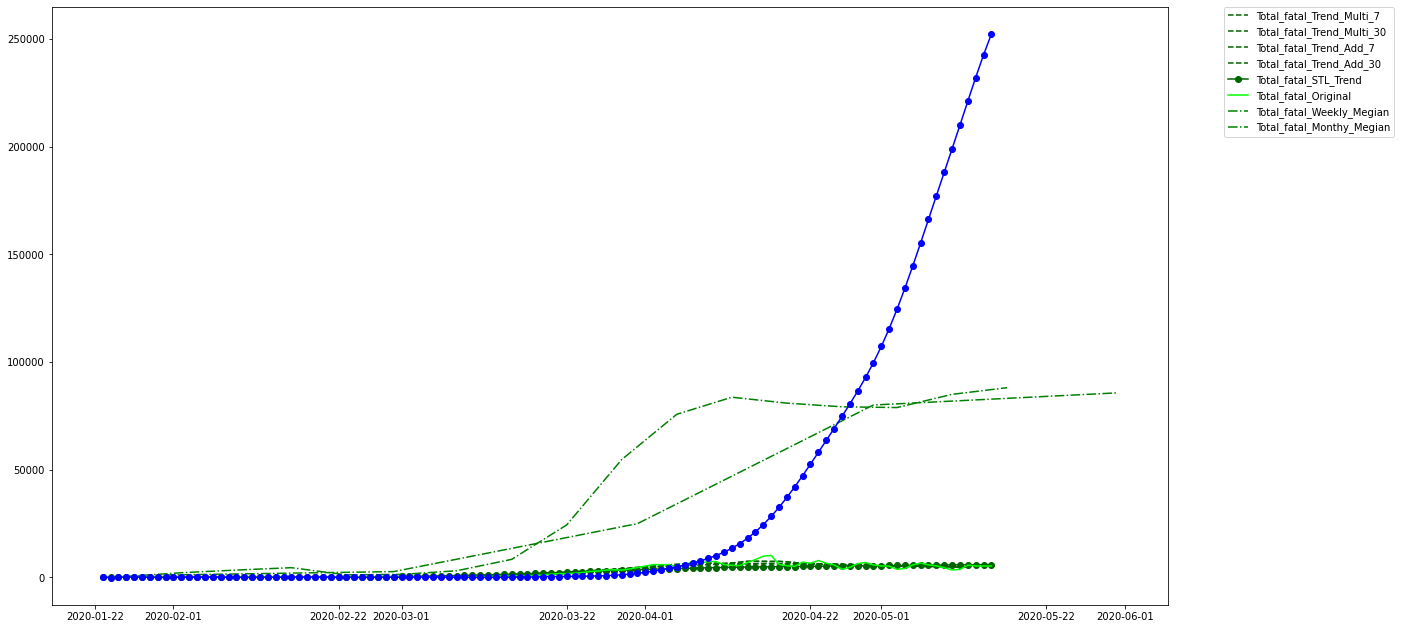

In [ ]:
res_ymw = seasonal_decompose(dta['Fatal_diff'], model='multiplicative', freq = 7)
# 1.2. Monthly
res_ymm = seasonal_decompose(dta['Fatal_diff'], model='multiplicative', freq = 30)

# 2. Additive 
# 2.1. Weekly
res_yaw = seasonal_decompose(dta['Fatal_diff'], model='additive', freq = 7)
# 2.2. Monthly
res_yam = seasonal_decompose(dta['Fatal_diff'], model='additive', freq = 30)

# 3. STL-Lib Decompopsition by LOESS - Logistic Regression:
stl_y = decompose(dta['Fatal_diff'], period=7)


# Just Aggregation:
# 1. Not Aggregated:
res_y = dta.Conf_diff

# 2. Aggregated by Week (Moving Median):
res_ymedw = dta.Conf_diff.resample('W').mean()

# 3. Aggregated by Month (Moving Median):
res_ymedm = dta.Conf_diff.resample('M').mean()


# Plotting Charts:
plt.figure(figsize=(20,11))
plt.plot(res_ymw.trend, '--', label='Total_fatal_Trend_Multi_7', color='darkgreen')
plt.plot(res_ymm.trend, '--', label='Total_fatal_Trend_Multi_30', color='darkgreen')
plt.plot(res_yaw.trend, '--', label='Total_fatal_Trend_Add_7', color='darkgreen')
plt.plot(res_yam.trend, '--', label='Total_fatal_Trend_Add_30', color='darkgreen')
plt.plot(stl_y.trend, '-o', label='Total_fatal_STL_Trend', color='darkgreen')

plt.plot(dta['Fatal_diff'], '-', label='Total_fatal_Original', color='lime')
plt.plot(res_ymedw, 'g-.', label='Total_fatal_Weekly_Megian')
plt.plot(res_ymedm, 'g-.', label='Total_fatal_Monthy_Megian')
plt.plot(dta.index, polynom( np.arange(len(dta.index)) ), 'b-o')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

ADF:  -3.39057454923798
p-value:  0.011284411943920544
Critical values:  {'1%': -3.497501033, '5%': -2.89090644, '10%': -2.5824349}
единичных корней нет, ряд стационарен
ADF:  -0.8036946716895904
p-value:  0.8180343758847705
Critical values:  {'1%': -3.4948504603223145, '5%': -2.889758398668639, '10%': -2.5818220155325444}
есть единичные корни, ряд не стационарен
ADF:  -1.021902592277306
p-value:  0.7451922523085773
Critical values:  {'1%': -3.4948504603223145, '5%': -2.889758398668639, '10%': -2.5818220155325444}
есть единичные корни, ряд не стационарен


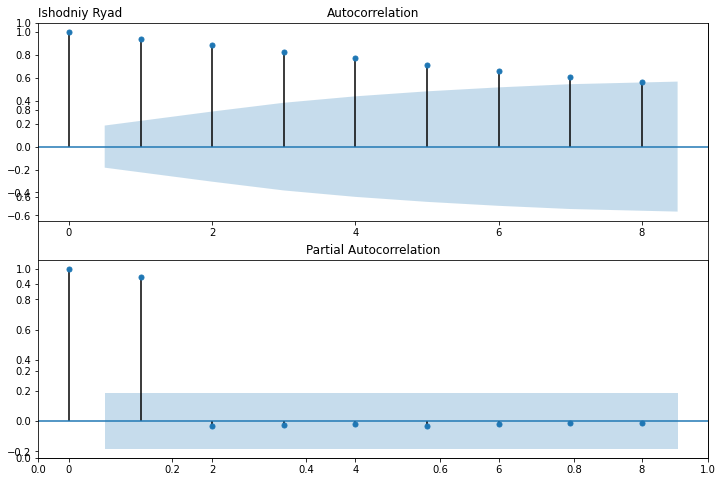

In [ ]:
trend = pd.DataFrame(data=(dta.Fatal_diff - polynom(np.arange(len(dta))) ) )
y1diff = trend.diff(periods=1).dropna() 

test = sm.tsa.stattools.adfuller(trend.iloc[:,0].values)
print('ADF: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print( 'есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')
# Единичные корни: Первая разность ряда
test = sm.tsa.stattools.adfuller(y1diff.iloc[:,0].values)
print('ADF: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')
    
y2diff = trend.diff(periods=2).dropna() # Вторая разность ряда   
#Единичные корни: Вторая разность ряда
test = sm.tsa.stattools.adfuller(y2diff.iloc[:,0].values)
print('ADF: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

fig = plt.figure(figsize=(12,8))
plt.title('Ishodniy Ryad', loc='left')
ax1 = fig.add_subplot(211)
fig = sm.api.graphics.tsa.plot_acf(trend.iloc[:,0].values.squeeze(), lags=8, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.api.graphics.tsa.plot_pacf(trend, lags=8
                                    , ax=ax2)


In [ ]:
res_ymw.trend

Date
2020-01-23            NaN
2020-01-24            NaN
2020-01-25            NaN
2020-01-26      16.571429
2020-01-27      21.857143
                 ...     
2020-05-11    4689.571429
2020-05-12    4677.000000
2020-05-13            NaN
2020-05-14            NaN
2020-05-15            NaN
Name: Fatal_diff, Length: 114, dtype: float64

Модель (0,0,2):

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



R^2: -2.61
MAPE: 5.792321
MAE: 278.074594


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



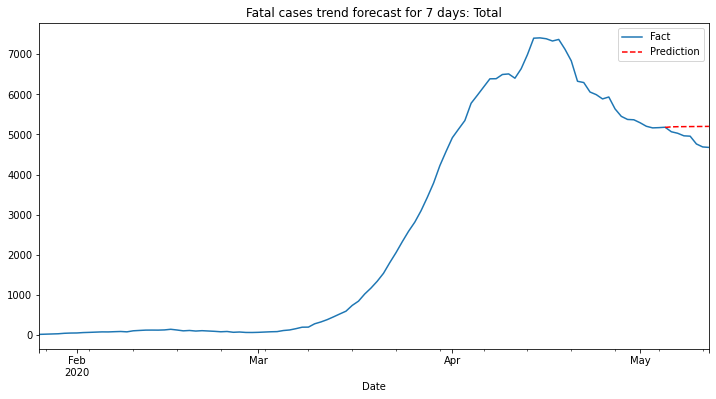

In [ ]:
src_data_model = res_ymw.trend['2020-01-26':'2020-05-05'].apply(lambda x: int(x))

model = sm.tsa.arima_model.ARIMA(src_data_model, (1,0,2))
model = model.fit()

pred = model.predict('2020-05-05', '2020-05-12')
trn = res_ymw.trend['2020-05-05':'2020-05-12']
r2 = r2_score(trn, pred)
print('R^2: %1.2f' % r2)
print('MAPE: %f' % MAPE(trn, pred))
print('MAE: %f' % mean_absolute_error(trn, pred))

res_ymw.trend['2020-01-26' : '2020-05-12'].apply(lambda x: int(x)).plot(figsize=(12,6), label = "Fact")
#src_data_model.plot()
pred.plot(style='r--', label = "Prediction")
plt.title("Fatal cases trend forecast for 7 days: Total")
plt.legend()

Как результат, имеем, по большей части, очень большие ошибки MAPE и MAE, а также отрицательный коэффициент детерминации. Данный результат может быть обоснован маленьким размером выборки, либо неправильным выбором модели. В некоторых случаях не удавалось подобрать модель в соответствии с тестом Дики-Фуллера, а подбиралась ближайшая по параметрам p и q, с сохранением параметра d.

Воспользуемся библиотекой pmdarima для автоматического подбора модели, причём не ARIMA модели, а её модификации -- SARIMAX модели.

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 45.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
df_russia = df_russia.dropna().set_index('Date')
df_russia

,Country_Region,ConfirmedCases,Fatalities,Conf_diff,Fatal_diff
Date,,,,,
2020-01-23,Russia,0.0,0.0,0.0,0.0
2020-01-24,Russia,0.0,0.0,0.0,0.0
2020-01-25,Russia,0.0,0.0,0.0,0.0
2020-01-26,Russia,0.0,0.0,0.0,0.0
2020-01-27,Russia,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2020-05-11,Russia,221344.0,2009.0,11656.0,94.0
2020-05-12,Russia,232243.0,2116.0,10899.0,107.0
2020-05-13,Russia,242271.0,2212.0,10028.0,96.0


In [ ]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df_russia["Conf_diff"])

(0.9582992903828744, True)

In [ ]:
train = df_russia["Conf_diff"][:-7]
test = df_russia["Conf_diff"][-7:]

In [ ]:
from pmdarima.arima import auto_arima

arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=7, seasonal=True, 
                          error_action="ignore",trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=1706.470, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=1517.808, Time=0.38 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=1623.859, Time=0.79 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=1736.093, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=1529.406, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=1506.334, Time=0.74 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=1504.381, Time=0.80 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=inf, Time=3.76 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=1693.317, Time=0.67 sec
 ARIMA(2,0,0)(0,1,1)[7] intercept   : AIC=1499.331, Time=2.19 sec
 ARIMA(2,0,0)(0,1,0)[7] intercept   : AIC=1521.374, Time=0.34 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=1500.970, Time=2.55 sec
 ARIMA(2,0,0)(0,1,2)[7] intercept   : AIC=inf, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  107
Model:             SARIMAX(2, 0, 0)x(0, 1, 1, 7)   Log Likelihood                -745.525
Date:                           Wed, 22 Dec 2021   AIC                           1499.050
Time:                                   13:11:19   BIC                           1509.470
Sample:                                        0   HQIC                          1503.267
                                           - 107                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7171      0.064     11.183      0.000       0.591       0.843
ar.L2          0.2829      0.066      4.302      0.000       0.154       0.412
ma.S.L7       -0.6097      0.097     -6.268      0.000      -0.800      -0.419
sigma2      1.693e+05   1.28e+04     13.274      0.000    1.44e+05    1.94e+05
===================================================================================
Ljung-Box (Q):                       47.76   Jarque-Bera (JB):               154.88
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):         2009827.44   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

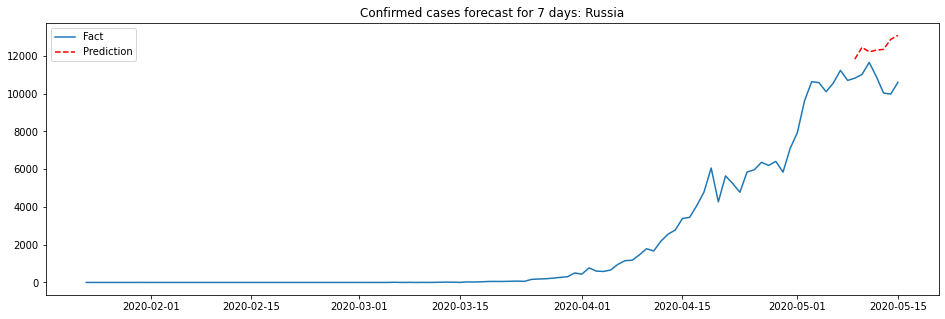

In [ ]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 7),index=test.index)
prediction.columns = ['pred']
prediction

plt.figure(figsize=(16,5))
#plt.plot(train,label="Training")
#plt.plot(test,label="Test")
plt.plot(df_russia["Conf_diff"], label = "Fact")
plt.plot(prediction,label="Prediction", ls = '--', color = "r")
plt.legend(loc = 'upper left')
plt.title("Confirmed cases forecast for 7 days: Russia")
plt.show()


In [ ]:
print('R^2: %1.2f' % r2_score(test, prediction))
print('MAPE: %f' % MAPE(test.values, prediction.values))
print('MAE: %f' % mean_absolute_error(test, prediction))

R^2: -11.33
MAPE: 16.445106
MAE: 1729.851138


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=1159.752, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=1087.885, Time=0.96 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=1172.959, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=1098.973, Time=0.36 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=1078.569, Time=1.77 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=1080.024, Time=1.12 sec
 ARIMA(0,0,1)(2,1,1)[7] intercept   : AIC=inf, Time=3.06 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=1078.480, Time=3.27 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=1083.525, Time=2.09 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=1079.722, Time=3.29 sec
 ARIMA(0,0,1)(1,1,3)[7] intercept   : AIC=1078.970, Time=7.05 sec
 ARIMA(0,0,1)(0,1,3)[7] intercept   : AIC=1081.332, Time=6.26 sec
 ARIMA(0,0,1)(2,1,3)[7] intercept   : AIC=inf, Time=7.38 sec
 ARIMA(0,0,0)(1,1,2)[7] intercept   : AIC=1101.9

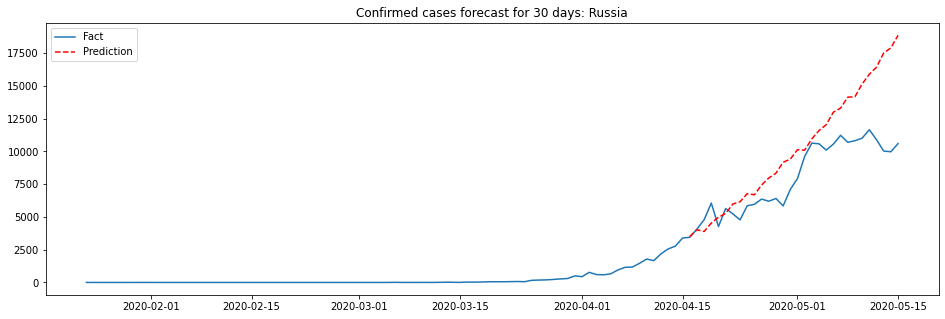

R^2: -0.57
MAPE: 70.087237
MAE: 2421.640898


In [ ]:
train = df_russia["Conf_diff"][:-30]
test = df_russia["Conf_diff"][-30:]

arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=7, seasonal=True, 
                          error_action="ignore",trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

prediction = pd.DataFrame(arima_model.predict(n_periods = 30),index=test.index)
prediction.columns = ['pred']
prediction

plt.figure(figsize=(16,5))
#plt.plot(train,label="Training")
#plt.plot(test,label="Test")
plt.plot(df_russia["Conf_diff"], label = "Fact")
plt.plot(prediction,label="Prediction", ls = '--', color = "r")
plt.legend(loc = 'upper left')
plt.title("Confirmed cases forecast for 30 days: Russia")
plt.show()

print('R^2: %1.2f' % r2_score(test, prediction))
print('MAPE: %f' % MAPE(test.values, prediction.values))
print('MAE: %f' % mean_absolute_error(test, prediction))

In [ ]:
adf_test.should_diff(df_russia["Fatal_diff"])

(0.99, True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=786.223, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=711.955, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=724.780, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=803.290, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=728.653, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=708.737, Time=0.60 sec
 ARIMA(1,0,0)(3,1,0)[7] intercept   : AIC=708.789, Time=1.13 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=709.220, Time=0.66 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=707.704, Time=0.35 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=708.736, Time=0.24 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=708.569, Time=0.64 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=706.705, Time=0.48 sec
 ARIMA(1,0,0)(0,1,3)[7] intercept   : AIC=708.553, Time=1.06 sec
 ARIMA(1,0,0)(1,1,3)[7] intercept   : AIC=710.552, Time=2.07 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=780.6

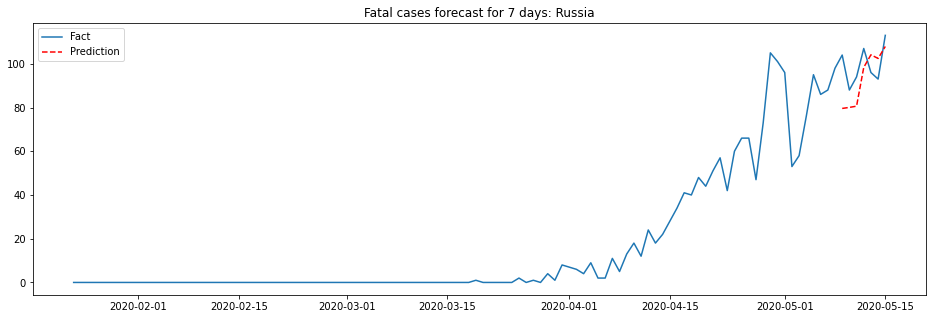

R^2: -1.30
MAPE: 13.023488
MAE: 11.005192


In [ ]:
train = df_russia["Fatal_diff"][:-7]
test = df_russia["Fatal_diff"][-7:]

arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=7, seasonal=True, 
                          error_action="ignore",trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

prediction = pd.DataFrame(arima_model.predict(n_periods = 7),index=test.index)
prediction.columns = ['pred']
prediction

plt.figure(figsize=(16,5))
#plt.plot(train,label="Training")
#plt.plot(test,label="Test")
plt.plot(df_russia["Fatal_diff"], label = "Fact")
plt.plot(prediction,label="Prediction", ls = '--', color = "r")
plt.legend(loc = 'upper left')
plt.title("Fatal cases forecast for 7 days: Russia")
plt.show()

print('R^2: %1.2f' % r2_score(test, prediction))
print('MAPE: %f' % MAPE(test.values, prediction.values))
print('MAE: %f' % mean_absolute_error(test, prediction))

In [ ]:
train = df_russia["Fatal_diff"][:-30]
test = df_russia["Fatal_diff"][-30:]

arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=7, seasonal=True, 
                          error_action="ignore",trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

prediction = pd.DataFrame(arima_model.predict(n_periods = 30),index=test.index)
prediction.columns = ['pred']
prediction



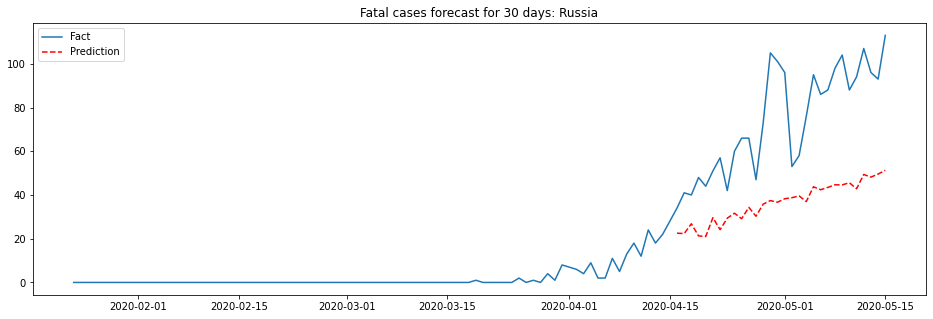

R^2: -1.92
MAPE: 46.438273
MAE: 37.606745


In [ ]:
plt.figure(figsize=(16,5))
#plt.plot(train,label="Training")
#plt.plot(test,label="Test")
plt.plot(df_russia["Fatal_diff"], label = "Fact")
plt.plot(prediction,label="Prediction", ls = '--', color = "r")
plt.legend(loc = 'upper left')
plt.title("Fatal cases forecast for 30 days: Russia")
plt.show()

print('R^2: %1.2f' % r2_score(test, prediction))
print('MAPE: %f' % MAPE(test.values, prediction.values))
print('MAE: %f' % mean_absolute_error(test, prediction))

In [ ]:
df_total = df_total.dropna().set_index('Date')
df_total

,Country_Region,ConfirmedCases,Fatalities,Conf_diff,Fatal_diff
Date,,,,,
2020-01-23,Total,653.0,18.0,99.0,1.0
2020-01-24,Total,939.0,26.0,286.0,8.0
2020-01-25,Total,1432.0,42.0,493.0,16.0
2020-01-26,Total,2113.0,56.0,681.0,14.0
2020-01-27,Total,2922.0,82.0,809.0,26.0
...,...,...,...,...,...
2020-05-11,Total,4176589.0,286293.0,75746.0,3619.0
2020-05-12,Total,4260955.0,291924.0,84366.0,5631.0
2020-05-13,Total,4345950.0,297155.0,84995.0,5231.0


In [ ]:
print(adf_test.should_diff(df_total["Conf_diff"]))
print(adf_test.should_diff(df_total["Fatal_diff"]))

(0.7579393858791234, True)
(0.8529049299410406, True)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=2146.161, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=2069.414, Time=0.32 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=2116.844, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=2170.021, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=2072.850, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=2061.505, Time=0.76 sec
 ARIMA(1,0,0)(3,1,0)[7] intercept   : AIC=2055.554, Time=1.34 sec
 ARIMA(1,0,0)(4,1,0)[7] intercept   : AIC=2057.015, Time=2.46 sec
 ARIMA(1,0,0)(3,1,1)[7] intercept   : AIC=2057.470, Time=2.51 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=2059.091, Time=1.05 sec
 ARIMA(1,0,0)(4,1,1)[7] intercept   : AIC=inf, Time=9.52 sec
 ARIMA(0,0,0)(3,1,0)[7] intercept   : AIC=2125.127, Time=0.91 sec
 ARIMA(2,0,0)(3,1,0)[7] intercept   : AIC=2038.237, Time=2.07 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=2038.939, Time=1.26 sec
 ARIMA(2,0,0)(4,1,0)[7] intercept   : 

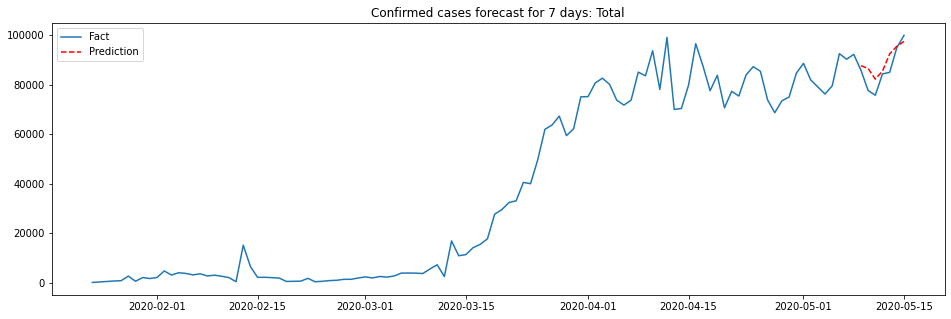

R^2: 0.59
MAPE: 9.964275
MAE: 4109.865481


In [ ]:
train = df_total["Conf_diff"][:-7]
test = df_total["Conf_diff"][-7:]

arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=7, seasonal=True, 
                          error_action="ignore",trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

prediction = pd.DataFrame(arima_model.predict(n_periods = 7),index=test.index)
prediction.columns = ['pred']
prediction

plt.figure(figsize=(16,5))
#plt.plot(train,label="Training")
#plt.plot(test,label="Test")
plt.plot(df_total["Conf_diff"], label = "Fact")
plt.plot(prediction,label="Prediction", ls = '--', color = "r")
plt.legend(loc = 'upper left')
plt.title("Confirmed cases forecast for 7 days: Total")
plt.show()


print('R^2: %1.2f' % r2_score(test, prediction))
print('MAPE: %f' % MAPE(test.values, prediction.values))
print('MAE: %f' % mean_absolute_error(test, prediction))

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=1658.438, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=1584.597, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=1630.151, Time=0.14 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=1684.557, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=1584.320, Time=0.04 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=1583.538, Time=0.16 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=1585.509, Time=0.37 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=1584.024, Time=0.57 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=1584.586, Time=0.96 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=1632.702, Time=0.45 sec
 ARIMA(2,0,0)(0,1,1)[7] intercept   : AIC=1563.504, Time=0.57 sec
 ARIMA(2,0,0)(0,1,0)[7] intercept   : AIC=1565.167, Time=0.13 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=1563.730, Time=0.80 sec
 ARIMA(2,0,0)(0,1,2)[7] intercept   : AIC=1561.003, Time=1.34 sec
 ARIMA(2,0,0)(1,1,2)[7] intercept

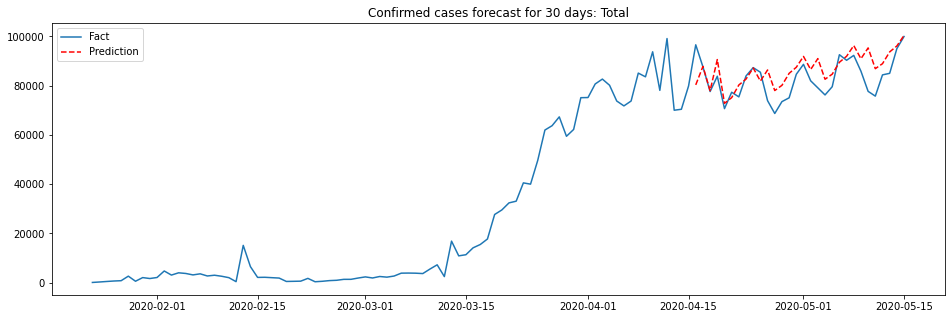

R^2: 0.13
MAPE: 11.007175
MAE: 5577.134148


In [ ]:
train = df_total["Conf_diff"][:-30]
test = df_total["Conf_diff"][-30:]

arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=7, seasonal=True, 
                          error_action="ignore",trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

prediction = pd.DataFrame(arima_model.predict(n_periods = 30),index=test.index)
prediction.columns = ['pred']
prediction

plt.figure(figsize=(16,5))
#plt.plot(train,label="Training")
#plt.plot(test,label="Test")
plt.plot(df_total["Conf_diff"], label = "Fact")
plt.plot(prediction,label="Prediction", ls = '--', color = "r")
plt.legend(loc = 'upper left')
plt.title("Confirmed cases forecast for 30 days: Total")
plt.show()

print('R^2: %1.2f' % r2_score(test, prediction))
print('MAPE: %f' % MAPE(test.values, prediction.values))
print('MAE: %f' % mean_absolute_error(test, prediction))

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=1685.364, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=1597.988, Time=0.32 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=1647.282, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=1693.918, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=1602.911, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=1596.742, Time=0.79 sec
 ARIMA(1,0,0)(3,1,0)[7] intercept   : AIC=1597.551, Time=1.85 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=1594.400, Time=2.95 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=1592.359, Time=1.15 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=1593.825, Time=0.65 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=1595.544, Time=4.18 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=1593.047, Time=2.70 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=inf, Time=5.99 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=1675.657, Time=0.30 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : 

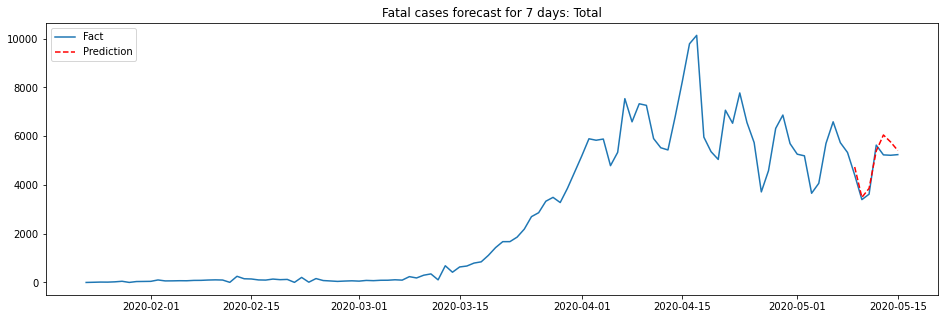

R^2: 0.74
MAPE: 23.433753
MAE: 346.757586


In [ ]:
train = df_total["Fatal_diff"][:-7]
test = df_total["Fatal_diff"][-7:]

arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=7, seasonal=True, 
                          error_action="ignore",trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

prediction = pd.DataFrame(arima_model.predict(n_periods = 7),index=test.index)
prediction.columns = ['pred']
prediction

plt.figure(figsize=(16,5))
#plt.plot(train,label="Training")
#plt.plot(test,label="Test")
plt.plot(df_total["Fatal_diff"], label = "Fact")
plt.plot(prediction,label="Prediction", ls = '--', color = "r")
plt.legend(loc = 'upper left')
plt.title("Fatal cases forecast for 7 days: Total")
plt.show()

print('R^2: %1.2f' % r2_score(test, prediction))
print('MAPE: %f' % MAPE(test.values, prediction.values))
print('MAE: %f' % mean_absolute_error(test, prediction))

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=1263.888, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=1160.966, Time=0.51 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=1206.863, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=1292.337, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=1170.931, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=1162.954, Time=1.20 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=1162.952, Time=0.76 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=1162.237, Time=0.48 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=1165.016, Time=1.53 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=1230.193, Time=0.38 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=1157.916, Time=0.50 sec
 ARIMA(2,0,0)(0,1,0)[7] intercept   : AIC=1160.415, Time=0.14 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=1159.783, Time=1.38 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=1159.784, Time=0.59 sec
 ARIMA(2,0,0)(0,1,1)[7] intercept

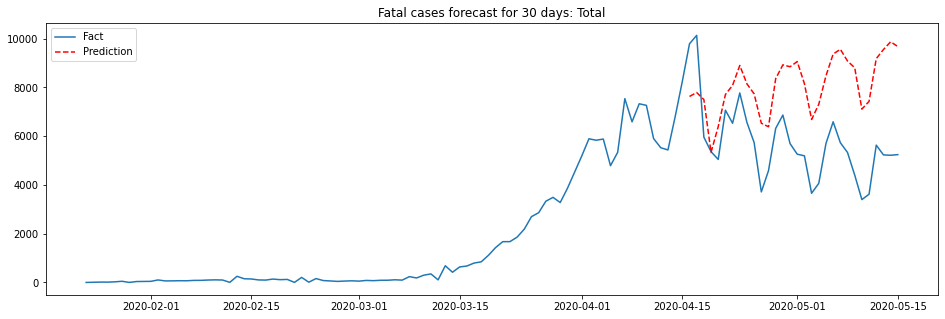

R^2: -2.65
MAPE: 55.075452
MAE: 2706.759085


In [ ]:
train = df_total["Fatal_diff"][:-30]
test = df_total["Fatal_diff"][-30:]

arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=7, seasonal=True, 
                          error_action="ignore",trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

prediction = pd.DataFrame(arima_model.predict(n_periods = 30),index=test.index)
prediction.columns = ['pred']
prediction

plt.figure(figsize=(16,5))
#plt.plot(train,label="Training")
#plt.plot(test,label="Test")
plt.plot(df_total["Fatal_diff"], label = "Fact")
plt.plot(prediction,label="Prediction", ls = '--', color = "r")
plt.legend(loc = 'upper left')
plt.title("Fatal cases forecast for 30 days: Total")
plt.show()

print('R^2: %1.2f' % r2_score(test, prediction))
print('MAPE: %f' % MAPE(test.values, prediction.values))
print('MAE: %f' % mean_absolute_error(test, prediction))

Можно констатировать, что результаты прогноза для мира оказались точнее в большинстве случаев. Это объясняется тем, что для мира есть больше информации, чем для России, потому что в России ковид активизировался несколько позже. Также ожидаемый результат, что при увеличении окна прогнозирования точность снижается. Однако можно заметить, что, по сравнению с ARIMA, прогноз SARIMAX модели лучше чувствует сезонность.

# **PROPHET**

In [68]:
# Reading data:
url_train = 'https://drive.google.com/file/d/1lI8A0dYsrLUnMK1hFDbFAPdpC1g9buJe/view?usp=sharing'
path_train = 'https://drive.google.com/uc?id=' + url_train.split('/')[-2]
train_data = pd.read_csv(path_train, sep=',')

# World:
total = train_data.drop(["Id", "Country_Region"], axis = 1).groupby("Date", as_index = False).sum()

# Russia:
russia = train_data.loc[train_data.Country_Region == "Russia"].drop(["Id", "Country_Region", "Province_State"], axis = 1)

# Diff row World:
total["Conf_diff"] = total['ConfirmedCases'] - total['ConfirmedCases'].shift(1)
total["Fatal_diff"] = total['Fatalities'] - total['Fatalities'].shift(1)

# Diff row Russia:
russia["Conf_diff"] = russia['ConfirmedCases'] - russia['ConfirmedCases'].shift(1)
russia["Fatal_diff"] = russia['Fatalities'] - russia['Fatalities'].shift(1)

Дальше мне интересен только дифференцированный ряд, поэтому приведем в порядок:

In [69]:
d_total = total.drop(["ConfirmedCases", "Fatalities"], axis=1).dropna()
d_total.columns = ["ds", "y1", "y2"]

d_russia = russia.drop(["ConfirmedCases", "Fatalities"], axis=1).dropna()
d_russia.columns = ["ds", "y1", "y2"]

d_total

,ds,y1,y2
1,2020-01-23,99.0,1.0
2,2020-01-24,286.0,8.0
3,2020-01-25,493.0,16.0
4,2020-01-26,681.0,14.0
5,2020-01-27,809.0,26.0
...,...,...,...
110,2020-05-11,75746.0,3619.0
111,2020-05-12,84366.0,5631.0
112,2020-05-13,84995.0,5231.0
113,2020-05-14,95024.0,5215.0


In [70]:
d_russia

,ds,y1,y2
23461,2020-01-23,0.0,0.0
23462,2020-01-24,0.0,0.0
23463,2020-01-25,0.0,0.0
23464,2020-01-26,0.0,0.0
23465,2020-01-27,0.0,0.0
...,...,...,...
23570,2020-05-11,11656.0,94.0
23571,2020-05-12,10899.0,107.0
23572,2020-05-13,10028.0,96.0
23573,2020-05-14,9974.0,93.0


Окей, визуализируем данные далее:

In [71]:
# Для начала посмотрим ConfCases по миру и по России
# со скользящим средним, чтобы наблюдать линию тренда:
d_total["ma_cc"] = d_total.y1.rolling(window=20).mean()
d_total["ma_fat"] = d_total.y2.rolling(window=20).mean() 

d_total.sort_values(by=["ds"])

d_russia["ma_cc"] = d_russia.y1.rolling(window=20).mean()
d_russia["ma_fat"] = d_russia.y2.rolling(window=20).mean() 

d_russia.sort_values(by=["ds"])

,ds,y1,y2,ma_cc,ma_fat
23461,2020-01-23,0.0,0.0,NaN,NaN
23462,2020-01-24,0.0,0.0,NaN,NaN
23463,2020-01-25,0.0,0.0,NaN,NaN
23464,2020-01-26,0.0,0.0,NaN,NaN
23465,2020-01-27,0.0,0.0,NaN,NaN
...,...,...,...,...,...
23570,2020-05-11,11656.0,94.0,8429.05,77.65
23571,2020-05-12,10899.0,107.0,8712.20,80.15
23572,2020-05-13,10028.0,96.0,8974.90,82.85
23573,2020-05-14,9974.0,93.0,9181.15,84.50


In [72]:
# Confirmed Cases World:
iplot([
    go.Scatter(x=d_total.ds , y=d_total.y1, name='fact_confirmed'),
    go.Scatter(x=d_total.ds , y=d_total.ma_cc, name='confirmed_moving_average_20_days') 
]);

In [73]:
# Fatalities World:
iplot([
    go.Scatter(x=d_total.ds , y=d_total.y2, name='fact_fatalities'),
    go.Scatter(x=d_total.ds , y=d_total.ma_fat, name='fact_moving_average_20_days') 
]);

In [74]:
# Confirmed Russia:
iplot([
    go.Scatter(x=d_russia.ds , y=d_russia.y1, name='fact_confirmed'),
    go.Scatter(x=d_russia.ds , y=d_russia.ma_cc, name='confirmed_moving_average_20_days') 
]);

In [75]:
# Fatal Russia:
iplot([
    go.Scatter(x=d_russia.ds , y=d_russia.y2, name='fact_fatal'),
    go.Scatter(x=d_russia.ds , y=d_russia.ma_fat, name='fatal_moving_average_20_days') 
]);

# **WORLD**

In [76]:
# преобразуем для prophet

# confirmed
df1 = d_total.drop(["y2", "ma_cc", "ma_fat"], axis=1)
df1.columns = ["ds", "y"]

# fatal
df2 = d_total.drop(["y1", "ma_cc", "ma_fat"], axis=1)
df2.columns = ["ds", "y"]

Начнем с прогноза Confirmed Cases по миру:

In [77]:
# start prediction with confirmed cases
m = Prophet()
m.fit(df1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [78]:
future = m.make_future_dataframe(periods=7 , freq = 'd')
forecast = m.predict(future)

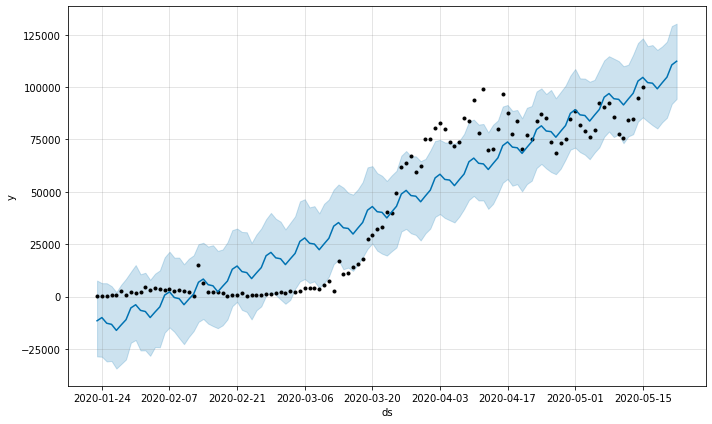

In [79]:
m.plot(forecast);

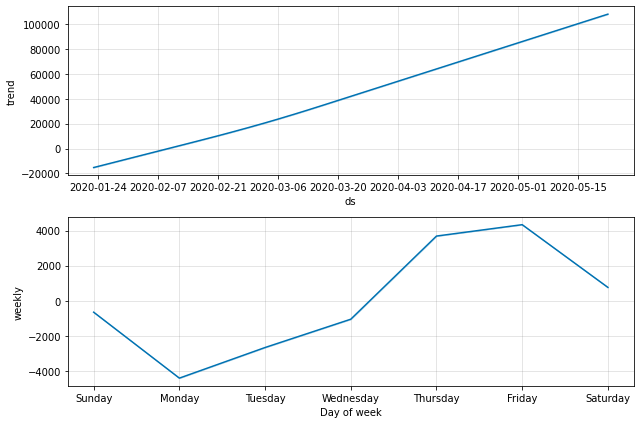

In [80]:
# decompose
m.plot_components(forecast);

In [81]:
forecast.tail(n=15) 

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
106,2020-05-08,92597.576038,78771.050887,114746.682835,92597.576038,92597.576038,4335.058165,4335.058165,4335.058165,4335.058165,4335.058165,4335.058165,0.0,0.0,0.0,96932.634203
107,2020-05-09,93698.376093,76163.888969,113596.381336,93698.376093,93698.376093,760.875008,760.875008,760.875008,760.875008,760.875008,760.875008,0.0,0.0,0.0,94459.251101
108,2020-05-10,94799.176148,77378.012132,112446.113539,94799.176148,94799.176148,-652.489890,-652.489890,-652.489890,-652.489890,-652.489890,-652.489890,0.0,0.0,0.0,94146.686258
109,2020-05-11,95899.976203,73207.777674,109962.119163,95899.976203,95899.976203,-4410.551341,-4410.551341,-4410.551341,-4410.551341,-4410.551341,-4410.551341,0.0,0.0,0.0,91489.424862
110,2020-05-12,97000.776258,76466.391867,110674.925570,97000.776258,97000.776258,-2665.840997,-2665.840997,-2665.840997,-2665.840997,-2665.840997,-2665.840997,0.0,0.0,0.0,94334.935261
111,2020-05-13,98101.576313,77514.453180,115474.233178,98101.576313,98101.576313,-1053.212359,-1053.212359,-1053.212359,-1053.212359,-1053.212359,-1053.212359,0.0,0.0,0.0,97048.363954
112,2020-05-14,99202.376368,83527.672952,121040.398980,99202.376368,99202.376368,3686.161415,3686.161415,3686.161415,3686.161415,3686.161415,3686.161415,0.0,0.0,0.0,102888.537783
113,2020-05-15,100303.176423,85556.736145,123262.424367,100303.176423,100303.176423,4335.058165,4335.058165,4335.058165,4335.058165,4335.058165,4335.058165,0.0,0.0,0.0,104638.234588
114,2020-05-16,101403.976478,83633.887292,119549.570505,101403.910895,101404.136531,760.875008,760.875008,760.875008,760.875008,760.875008,760.875008,0.0,0.0,0.0,102164.851486
115,2020-05-17,102504.776533,81808.655752,120063.704940,102500.299587,102508.881726,-652.489890,-652.489890,-652.489890,-652.489890,-652.489890,-652.489890,0.0,0.0,0.0,101852.286642


Далее следует сделать *валидацию* нашего прогноза по этой метрике:

In [82]:
predictions_period = 7

train_df = df1[:-predictions_period] 

m = Prophet()
m.fit(train_df)

future = m.make_future_dataframe(periods=predictions_period, freq='d')
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#Считаем ошибки прогноза

new_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper','trend']].join(df1.set_index('ds'))

new_df['e'] = new_df['y'] - new_df['yhat']
new_df['p'] = 100 * new_df['e']/new_df['y']

abs_p = abs(new_df[-predictions_period:]['p'])
abs_e = abs(new_df[-predictions_period:]['e'])

print ('MAPE - ошибка в процентах', str(round(np.mean(abs(new_df[-predictions_period:]['p'])),2))+'%')
print ('MAE - абсолютная ошибка', round(np.mean(abs(new_df[-predictions_period:]['e'])),2))


MAPE - ошибка в процентах 18.58%
MAE - абсолютная ошибка 15529.13


In [88]:
print('R^2: %1.2f' % r2_score(df1.y[-7:], forecast.yhat[-7:]))

R^2: -2.99


In [86]:
df1.y[-7:]

108    85851.0
109    77673.0
110    75746.0
111    84366.0
112    84995.0
113    95024.0
114    99952.0
Name: y, dtype: float64

**Мы получили ошибку прогноза в 18%**

In [ ]:
iplot([
    go.Scatter(x=new_df.tail(10000).index , y=new_df.tail(10000).y, name='fact'),
    go.Scatter(x=new_df.tail(predictions_period).index, y=new_df.tail(predictions_period).yhat, name='forecast'),
    go.Scatter(x=new_df.tail(predictions_period).index, y=new_df.tail(predictions_period).yhat_lower, fill='tonexty', mode='none', name='lower_bound'),
     go.Scatter(x=new_df.tail(predictions_period).index, y=new_df.tail(predictions_period).yhat_upper, fill='tonexty', mode='none', name='upper_bound')
])

print ('MAPE - ошибка в процентах', str(round(np.mean(abs(new_df[-predictions_period:]['p'])),2))+'%')
print ('MAE - абсолютная ошибка', round(np.mean(abs(new_df[-predictions_period:]['e'])),0))

print("Confirmed Cases - World")

MAPE - ошибка в процентах 18.58%
MAE - абсолютная ошибка 15529.0
Confirmed Cases - World


Приступим к прогнозу Fatalities по миру:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


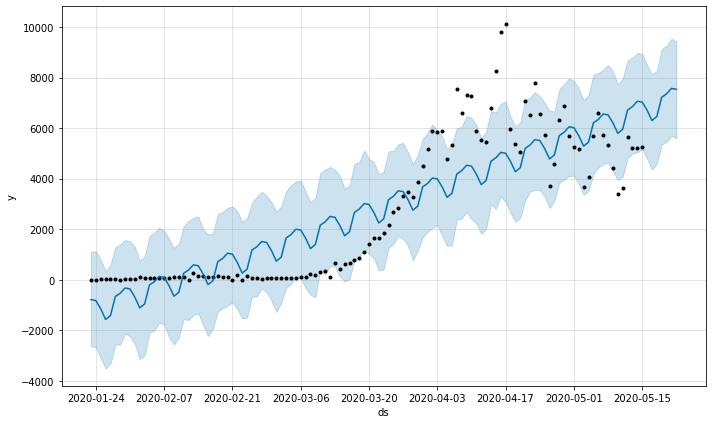

In [89]:
m = Prophet()
m.fit(df2)
future = m.make_future_dataframe(periods=7 , freq = 'd')
forecast = m.predict(future)
m.plot(forecast);

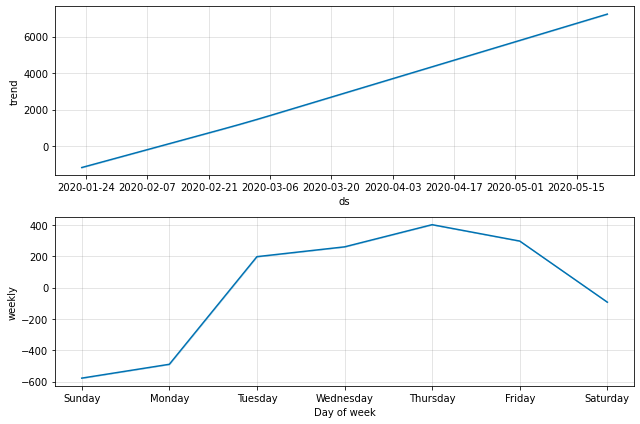

In [90]:
# decompose
m.plot_components(forecast);

По сравнению с количествомм зарегестрированных слуаев, смерность имеет максимум в четверг (не знаю о чем это говорит), зарегестрированные случаи имеют максимум в конце рабочей части недели --- просто к сведению. 

In [91]:
forecast.tail(n=7) 

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
114,2020-05-16,6804.549464,4791.002028,8497.225764,6804.549464,6804.549464,-92.591095,-92.591095,-92.591095,-92.591095,-92.591095,-92.591095,0.0,0.0,0.0,6711.958370
115,2020-05-17,6876.865065,4351.295497,8120.878733,6876.749470,6876.981173,-578.251648,-578.251648,-578.251648,-578.251648,-578.251648,-578.251648,0.0,0.0,0.0,6298.613417
116,2020-05-18,6949.180666,4584.571440,8262.780185,6948.857470,6949.478260,-489.700290,-489.700290,-489.700290,-489.700290,-489.700290,-489.700290,0.0,0.0,0.0,6459.480376
117,2020-05-19,7021.496266,5355.805620,9128.116061,7020.923925,7022.120850,198.407031,198.407031,198.407031,198.407031,198.407031,198.407031,0.0,0.0,0.0,7219.903297
118,2020-05-20,7093.811867,5457.548453,9266.715528,7092.858772,7094.830575,261.067557,261.067557,261.067557,261.067557,261.067557,261.067557,0.0,0.0,0.0,7354.879424
119,2020-05-21,7166.127468,5691.155023,9531.446554,7164.738559,7167.465052,402.909645,402.909645,402.909645,402.909645,402.909645,402.909645,0.0,0.0,0.0,7569.037113
120,2020-05-22,7238.443068,5597.002191,9441.904934,7236.577557,7240.311592,298.158800,298.158800,298.158800,298.158800,298.158800,298.158800,0.0,0.0,0.0,7536.601869


Хорошо, прогноз сделан. Проведем *валидацию*: отрежем последние 15 дней, так как какие-то изменения начали происходить примерно в последние два месяца наблюдения. COVID - нечто новое и начинает только набирать обороты (в наших данных), так что, возможно, целесообразно вовсе даже не 30 дней отрезать, а 15, уже по ним определить качество прогноза.

*По метрике Confirm Cases, если определять качество прогноза по этому промежутку, ошибка дает 30%, что уже не так много.*

In [92]:
predictions_period = 7

train_df = df2[:-predictions_period] 

m = Prophet()
m.fit(train_df)

future = m.make_future_dataframe(periods=predictions_period, freq='d')
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [93]:
#Считаем ошибки прогноза

new_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper','trend']].join(df2.set_index('ds'))

new_df['e'] = new_df['y'] - new_df['yhat']
new_df['p'] = 100 * new_df['e']/new_df['y']

abs_p = abs(new_df[-predictions_period:]['p'])
abs_e = abs(new_df[-predictions_period:]['e'])

print ('MAPE - ошибка в процентах', str(round(np.mean(abs(new_df[-predictions_period:]['p'])),2))+'%')
print ('MAE - абсолютная ошибка', round(np.mean(abs(new_df[-predictions_period:]['e'])),2))

MAPE - ошибка в процентах 61.6%
MAE - абсолютная ошибка 2711.35


In [94]:
print('R^2: %1.2f' % r2_score(df2.y[-7:], forecast.yhat[-7:]))

R^2: -10.33


**Большая ошибка.**

In [ ]:
iplot([
    go.Scatter(x=new_df.tail(10000).index , y=new_df.tail(10000).y, name='fact'),
    go.Scatter(x=new_df.tail(predictions_period).index, y=new_df.tail(predictions_period).yhat, name='forecast'),
    go.Scatter(x=new_df.tail(predictions_period).index, y=new_df.tail(predictions_period).yhat_lower, fill='tonexty', mode='none', name='lower_bound'),
     go.Scatter(x=new_df.tail(predictions_period).index, y=new_df.tail(predictions_period).yhat_upper, fill='tonexty', mode='none', name='upper_bound')
])

print ('MAPE - ошибка в процентах', str(round(np.mean(abs(new_df[-predictions_period:]['p'])),2))+'%')
print ('MAE - абсолютная ошибка', round(np.mean(abs(new_df[-predictions_period:]['e'])),0))

print("Fatalities - World")

MAPE - ошибка в процентах 61.6%
MAE - абсолютная ошибка 2711.0
Fatalities - World


**Итак, мы получили прогноз по миру.**

# **RUSSIA**

In [95]:
# преобразуем для prophet

# confirmed
df1 = d_russia.drop(["y2", "ma_cc", "ma_fat"], axis=1)
df1.columns = ["ds", "y"]

# fatal
df2 = d_russia.drop(["y1", "ma_cc", "ma_fat"], axis=1)
df2.columns = ["ds", "y"]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


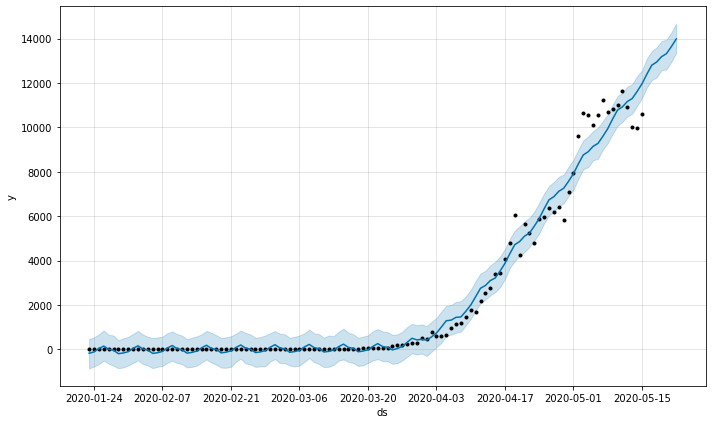

In [96]:
# start predictions with confirmed cases:
m = Prophet()
m.fit(df1)
future = m.make_future_dataframe(periods=7 , freq = 'd')
forecast = m.predict(future)
m.plot(forecast);

In [97]:
forecast.tail(n=7) 

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
114,2020-05-16,12317.788892,11800.241133,13102.237273,12317.453073,12317.788892,84.164348,84.164348,84.164348,84.164348,84.164348,84.164348,0.0,0.0,0.0,12401.953240
115,2020-05-17,12606.720278,12135.953924,13440.290500,12599.364903,12611.420350,197.280668,197.280668,197.280668,197.280668,197.280668,197.280668,0.0,0.0,0.0,12804.000945
116,2020-05-18,12895.651663,12251.811473,13608.532590,12877.298275,12909.212876,51.214284,51.214284,51.214284,51.214284,51.214284,51.214284,0.0,0.0,0.0,12946.865947
117,2020-05-19,13184.583049,12581.167376,13889.720521,13151.909080,13210.012240,4.167129,4.167129,4.167129,4.167129,4.167129,4.167129,0.0,0.0,0.0,13188.750177
118,2020-05-20,13473.514435,12616.669429,13954.726814,13428.250836,13512.689176,-150.614729,-150.614729,-150.614729,-150.614729,-150.614729,-150.614729,0.0,0.0,0.0,13322.899706
119,2020-05-21,13762.445820,12955.315085,14281.349615,13699.838861,13817.062204,-121.519788,-121.519788,-121.519788,-121.519788,-121.519788,-121.519788,0.0,0.0,0.0,13640.926032
120,2020-05-22,14051.377206,13354.553049,14676.418082,13972.410978,14122.619130,-64.691911,-64.691911,-64.691911,-64.691911,-64.691911,-64.691911,0.0,0.0,0.0,13986.685295


*Валидация:*

In [98]:
predictions_period = 7

train_df = df1[:-predictions_period] 

m = Prophet()
m.fit(train_df)

future = m.make_future_dataframe(periods=predictions_period, freq='d')
forecast = m.predict(future)

# Считаем ошибки прогноза:
new_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper','trend']].join(df1.set_index('ds'))

new_df['e'] = new_df['y'] - new_df['yhat']
new_df['p'] = 100 * new_df['e']/new_df['y']

abs_p = abs(new_df[-predictions_period:]['p'])
abs_e = abs(new_df[-predictions_period:]['e'])

print ('MAPE - ошибка в процентах', str(round(np.mean(abs(new_df[-predictions_period:]['p'])),2))+'%')
print ('MAE - абсолютная ошибка', round(np.mean(abs(new_df[-predictions_period:]['e'])),2))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE - ошибка в процентах 12.44%
MAE - абсолютная ошибка 1284.57


In [99]:
print('R^2: %1.2f' % r2_score(df1.y[-7:], forecast.yhat[-7:]))

R^2: -8.13


**Ошибка 14%** 

In [100]:
iplot([
    go.Scatter(x=new_df.tail(10000).index , y=new_df.tail(10000).y, name='fact'),
    go.Scatter(x=new_df.tail(predictions_period).index, y=new_df.tail(predictions_period).yhat, name='forecast'),
    go.Scatter(x=new_df.tail(predictions_period).index, y=new_df.tail(predictions_period).yhat_lower, fill='tonexty', mode='none', name='lower_bound'),
     go.Scatter(x=new_df.tail(predictions_period).index, y=new_df.tail(predictions_period).yhat_upper, fill='tonexty', mode='none', name='upper_bound')
])

print ('MAPE - ошибка в процентах', str(round(np.mean(abs(new_df[-predictions_period:]['p'])),2))+'%')
print ('MAE - абсолютная ошибка', round(np.mean(abs(new_df[-predictions_period:]['e'])),0))

print("Confirmed Cases - Russia")

MAPE - ошибка в процентах 12.44%
MAE - абсолютная ошибка 1285.0
Confirmed Cases - Russia


Далее прогнозируем смерность по России:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


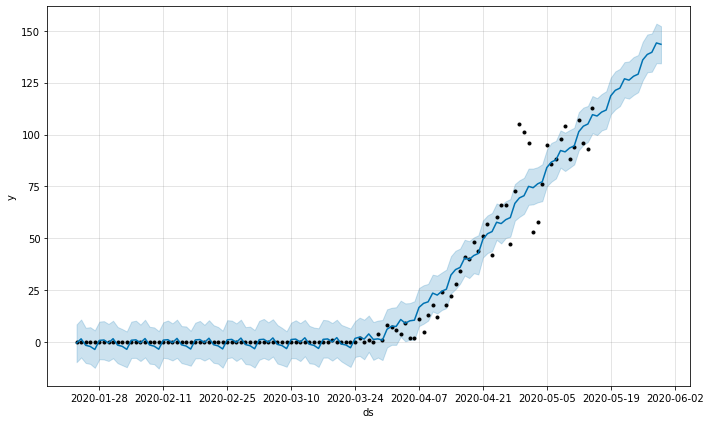

In [101]:
m = Prophet()
m.fit(df2)
future = m.make_future_dataframe(periods=15 , freq = 'd')
forecast = m.predict(future)
m.plot(forecast);

In [102]:
forecast.tail(n=7) 

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
122,2020-05-24,129.593155,119.053379,137.320616,128.491527,130.528903,-1.500334,-1.500334,-1.500334,-1.500334,-1.500334,-1.500334,0.0,0.0,0.0,128.092821
123,2020-05-25,132.062437,120.400926,138.303136,130.729076,133.160200,-2.963931,-2.963931,-2.963931,-2.963931,-2.963931,-2.963931,0.0,0.0,0.0,129.098506
124,2020-05-26,134.531720,126.089106,144.662314,132.967523,135.850784,1.411296,1.411296,1.411296,1.411296,1.411296,1.411296,0.0,0.0,0.0,135.943016
125,2020-05-27,137.001002,130.000737,148.193579,135.212397,138.578092,1.595120,1.595120,1.595120,1.595120,1.595120,1.595120,0.0,0.0,0.0,138.596122
126,2020-05-28,139.470285,130.271090,148.704315,137.473681,141.350803,0.168928,0.168928,0.168928,0.168928,0.168928,0.168928,0.0,0.0,0.0,139.639212
127,2020-05-29,141.939567,134.385150,153.442591,139.709561,144.051620,2.204632,2.204632,2.204632,2.204632,2.204632,2.204632,0.0,0.0,0.0,144.144199
128,2020-05-30,144.408850,134.316312,152.225965,141.893458,146.815183,-0.915711,-0.915711,-0.915711,-0.915711,-0.915711,-0.915711,0.0,0.0,0.0,143.493139


Проведем *валидацию* нашего прогноза:

In [103]:
predictions_period = 7

train_df = df2[:-predictions_period] 

m = Prophet()
m.fit(train_df)

future = m.make_future_dataframe(periods=predictions_period, freq='d')
forecast = m.predict(future)

# Считаем ошибки прогноза:
new_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper','trend']].join(df2.set_index('ds'))

new_df['e'] = new_df['y'] - new_df['yhat']
new_df['p'] = 100 * new_df['e']/new_df['y']

abs_p = abs(new_df[-predictions_period:]['p'])
abs_e = abs(new_df[-predictions_period:]['e'])

print ('MAPE - ошибка в процентах', str(round(np.mean(abs(new_df[-predictions_period:]['p'])),2))+'%')
print ('MAE - абсолютная ошибка', round(np.mean(abs(new_df[-predictions_period:]['e'])),2))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE - ошибка в процентах 7.83%
MAE - абсолютная ошибка 7.54


In [105]:
print('R^2: %1.2f' % r2_score(df2.y[-7:], forecast.yhat[-7:]))

R^2: -0.18


Ошибка 7%

In [104]:
iplot([
    go.Scatter(x=new_df.tail(10000).index , y=new_df.tail(10000).y, name='fact'),
    go.Scatter(x=new_df.tail(predictions_period).index, y=new_df.tail(predictions_period).yhat, name='forecast'),
    go.Scatter(x=new_df.tail(predictions_period).index, y=new_df.tail(predictions_period).yhat_lower, fill='tonexty', mode='none', name='lower_bound'),
     go.Scatter(x=new_df.tail(predictions_period).index, y=new_df.tail(predictions_period).yhat_upper, fill='tonexty', mode='none', name='upper_bound')
])

print ('MAPE - ошибка в процентах', str(round(np.mean(abs(new_df[-predictions_period:]['p'])),2))+'%')
print ('MAE - абсолютная ошибка', round(np.mean(abs(new_df[-predictions_period:]['e'])),0))

print("Fatalities - Russia")

MAPE - ошибка в процентах 7.83%
MAE - абсолютная ошибка 8.0
Fatalities - Russia


**Прогноз по России сделан.**

*Результаты прогнозов отразим в презентации.*